Connected to FiftyOne on port 5151 at localhost.
If you are not connecting to a remote session, you may need to start a new session and specify a port



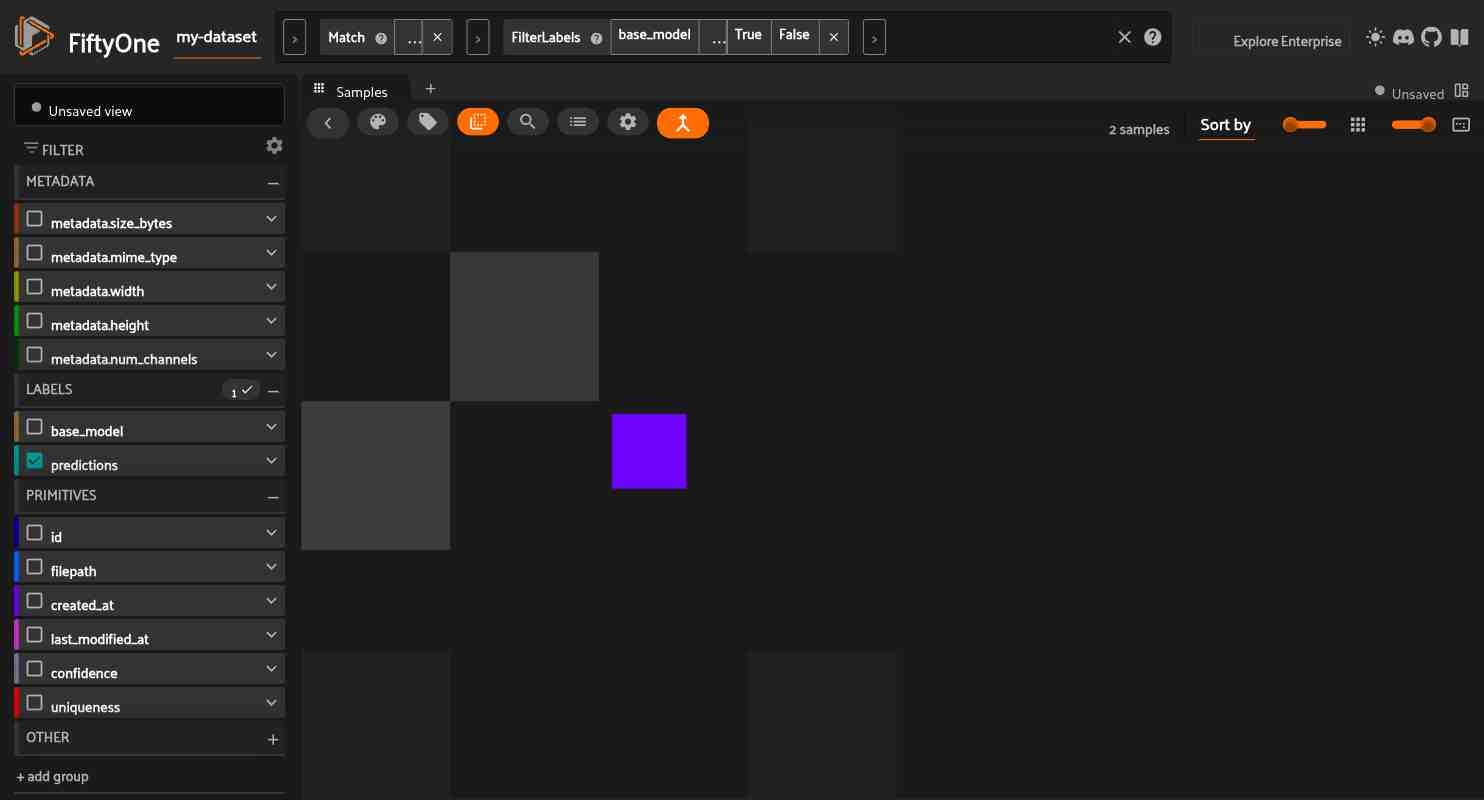

In [2]:
import fiftyone as fo  

# 加载已存在的数据集  
dataset = fo.load_dataset("my-dataset")
session = fo.launch_app(dataset)

In [6]:
from ultralytics import YOLO

ckpt_path = "yolov8l.pt"
model = YOLO(ckpt_path)
## fiftyone will work directly with the Ultralytics.YOLO model

dataset.apply_model(model, label_field="base_model", confidence_thresh=0.1)

 100% |█████████████████████| 6/6 [964.0ms elapsed, 0s remaining, 6.2 samples/s]      


In [ ]:
from fiftyone import ViewField as F

def get_label_fields(sample_collection):
    """Get the (detection) label fields of a Dataset or DatasetView."""
    label_fields = list(
        sample_collection.get_field_schema(embedded_doc_type=fo.Detections).keys()
    )
    return label_fields

def filter_all_labels(sample_collection):
    label_fields = get_label_fields(sample_collection)
    print(f"Filtering labels in fields: {label_fields}")
    filtered_view = sample_collection

    for lf in label_fields:
        filtered_view = filtered_view.filter_labels(
            lf, F("label").is_in(["person", "car", "truck"]), only_matches=False
        )
    return filtered_view

In [ ]:
filtered_view = filter_all_labels(dataset)

Filtering labels in fields: ['predictions', 'ground_truth', 'small_slices', 'large_slices']


In [ ]:
session.view = filtered_view.view()


In [40]:
from sahi import AutoDetectionModel
from sahi.predict import get_prediction, get_sliced_prediction

In [41]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=ckpt_path,
    confidence_threshold=0.1, ## same as the default value for our base model
    image_size=640,
    device="cuda", # or 'cuda'
)

In [ ]:
# 只需获取第一个图像的预测结果
result = get_prediction(dataset.first().filepath, detection_model, verbose=1)
print(result)

Prediction performed in 0.06888604164123535 seconds.


In [ ]:
print(result.to_fiftyone_detections())

[<Detection: {
    'id': '693bb003204e4ad6665e93e7',
    'attributes': {},
    'tags': [],
    'label': 'umbrella',
    'bounding_box': [
        0.0,
        0.16041348455154106,
        0.9994644217474764,
        0.8185629768284289,
    ],
    'mask': None,
    'mask_path': None,
    'confidence': 0.729188859462738,
    'index': None,
}>, <Detection: {
    'id': '693bb003204e4ad6665e93e8',
    'attributes': {},
    'tags': [],
    'label': 'cake',
    'bounding_box': [
        0.00017433166759939946,
        0.1650308045969948,
        0.9993650731326583,
        0.8144865930762389,
    ],
    'mask': None,
    'mask_path': None,
    'confidence': 0.1716228574514389,
    'index': None,
}>]


In [ ]:
# 获取切片预测结果
sliced_result = get_sliced_prediction(
    dataset.first().filepath,
    detection_model,
    slice_height = 640,
    slice_width = 640,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2,
)

In [47]:
sliced_result

In [48]:
print(sliced_result.to_fiftyone_detections())

[<Detection: {
    'id': '693bb0c5204e4ad6665e93e9',
    'attributes': {},
    'tags': [],
    'label': 'boat',
    'bounding_box': [
        0.11022751273977797,
        0.17920211687240775,
        0.13699911058563546,
        0.14950149501215676,
    ],
    'mask': None,
    'mask_path': None,
    'confidence': 0.3413856327533722,
    'index': None,
}>, <Detection: {
    'id': '693bb0c5204e4ad6665e93ea',
    'attributes': {},
    'tags': [],
    'label': 'bird',
    'bounding_box': [
        0.5543128649393717,
        0.21862287543185516,
        0.015299854409653707,
        0.014360502055362379,
    ],
    'mask': None,
    'mask_path': None,
    'confidence': 0.3524176776409149,
    'index': None,
}>, <Detection: {
    'id': '693bb0c5204e4ad6665e93eb',
    'attributes': {},
    'tags': [],
    'label': 'bird',
    'bounding_box': [
        0.32012628116148856,
        0.5233691846205932,
        0.020765107931550016,
        0.024150612697994137,
    ],
    'mask': None,
    'ma

In [49]:
num_sliced_dets = len(sliced_result.to_fiftyone_detections())
num_orig_dets = len(result.to_fiftyone_detections())

print(f"Detections predicted without slicing: {num_orig_dets}")
print(f"Detections predicted with slicing: {num_sliced_dets}")

Detections predicted without slicing: 2
Detections predicted with slicing: 44


In [53]:
# 定义一个函数来预测切片结果
def predict_with_slicing(sample, label_field, **kwargs):
    result = get_sliced_prediction(
        sample.filepath, detection_model, verbose=0, **kwargs
    )
    sample[label_field] = fo.Detections(detections=result.to_fiftyone_detections())

In [54]:
kwargs = {"overlap_height_ratio": 0.2, "overlap_width_ratio": 0.2}

for sample in dataset.iter_samples(progress=True, autosave=True):
    predict_with_slicing(sample, label_field="small_slices", slice_height=320, slice_width=320, **kwargs)
    predict_with_slicing(sample, label_field="large_slices", slice_height=480, slice_width=480, **kwargs)

 100% |█████████████████████| 6/6 [29.1s elapsed, 0s remaining, 0.2 samples/s]    


In [68]:
# base_results = session.view.evaluate_detections("base_model", gt_field="ground_truth", eval_key="eval_base_model")
large_slice_results = session.view.evaluate_detections("large_slices", gt_field="ground_truth", eval_key="eval_large_slices")
small_slice_results = session.view.evaluate_detections("small_slices", gt_field="ground_truth", eval_key="eval_small_slices")

Evaluating detections...
 100% |█████████████████████| 3/3 [332.5ms elapsed, 0s remaining, 9.0 samples/s]      
Evaluating detections...
 100% |█████████████████████| 3/3 [6.4ms elapsed, 0s remaining, 469.7 samples/s] 


In [69]:
# print("Base model results:")
# base_results.print_report()

print("-" * 50)
print("Large slice results:")
large_slice_results.print_report()

print("-" * 50)
print("Small slice results:")
small_slice_results.print_report()

--------------------------------------------------
Large slice results:
               precision    recall  f1-score   support

     airplane       0.00      0.00      0.00         0
        apple       0.00      0.00      0.00         0
         bear       0.00      0.00      0.00         0
         bird       0.00      0.00      0.00         0
         boat       0.00      0.00      0.00         0
     broccoli       0.00      0.00      0.00         0
         cake       0.17      1.00      0.29         2
          car       0.00      0.00      0.00         0
       carrot       0.00      0.00      0.00         0
          cup       0.00      0.00      0.00         0
 dining table       0.00      0.00      0.00         2
      frisbee       0.00      0.00      0.00         0
         kite       0.00      0.00      0.00         0
       laptop       0.00      0.00      0.00         0
        mouse       0.00      0.00      0.00         0
       orange       0.00      0.00      0.00   

### 评估小型物体的性能-像素小于32X32

In [92]:
## Filtering for only small boxes
import fiftyone as fo
from fiftyone import ViewField as F

dataset.compute_metadata()  


Computing metadata...
 100% |█████████████████████| 6/6 [16.3ms elapsed, 0s remaining, 367.5 samples/s] 


In [ ]:
box_width, box_height = F("bounding_box")[2], F("bounding_box")[3]  
box_width, box_height


({'$arrayElemAt': ['$bounding_box', 2]},
 {'$arrayElemAt': ['$bounding_box', 3]})

In [95]:
rel_bbox_area = box_width * box_height  
rel_bbox_area

{
    '$multiply': [
        {'$arrayElemAt': ['$bounding_box', 2]},
        {'$arrayElemAt': ['$bounding_box', 3]},
    ],
}

In [96]:
im_width, im_height = F("$metadata.width"), F("$metadata.height")  
im_width, im_height

('$metadata.width', '$metadata.height')

In [97]:
abs_area = rel_bbox_area * im_width * im_height  
abs_area

{
    '$multiply': [
        {
            '$multiply': [
                {
                    '$multiply': [
                        {'$arrayElemAt': ['$bounding_box', 2]},
                        {'$arrayElemAt': ['$bounding_box', 3]},
                    ],
                },
                '$metadata.width',
            ],
        },
        '$metadata.height',
    ],
}

In [118]:
small_boxes_view = dataset.view()
for lf in get_label_fields(dataset):  
    small_boxes_view = small_boxes_view.filter_labels(  
        lf, abs_area < 32**2, only_matches=False  
    )  


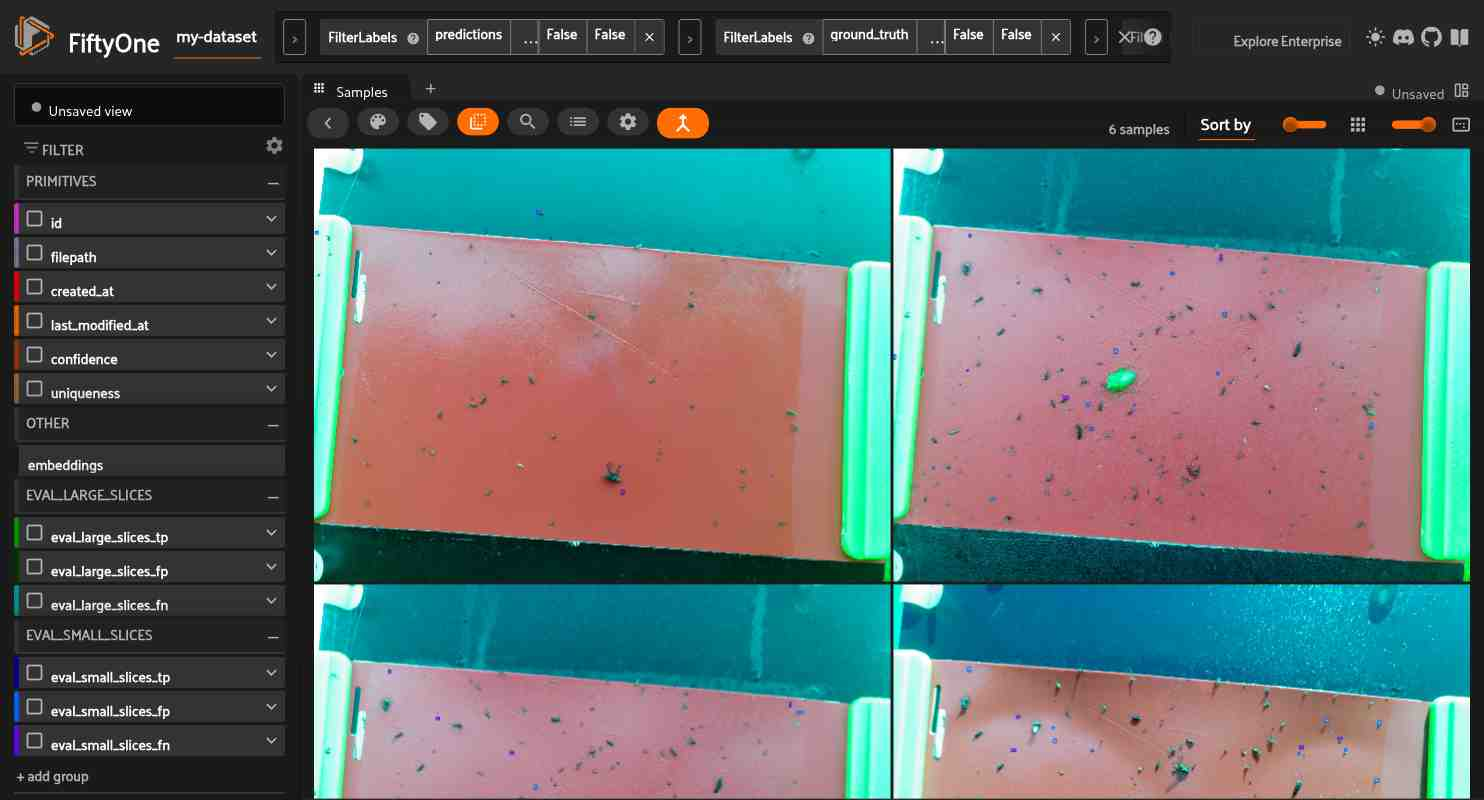

In [119]:
session.view = small_boxes_view.view()


In [ ]:
high_conf_fp_view = dataset.to_evaluation_patches(eval_key="eval_small_slices").match(F("type")=="fp").sort_by("small_slices.detection.confidence")

In [123]:
session.view = high_conf_fp_view.view()
